In [4]:
from tqdm import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data1
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle as pkl
from analysis import epsilon_calculation
from analysis import batch_samplers
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.distributions.normal import Normal

nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs=500
batch_size=128
lr = 0.002
ngpu = 1
beta1=0.5

data=pkl.load(open('data1/X_processed.pkl', 'rb'))
data=np.expand_dims(data, axis=1)
data=torch.from_numpy(data).float()
print(len(data))
class MyDataset(data1.Dataset):
    def __init__(self, data):
        
        self.data = data

    def __getitem__(self, index):
       
        return self.data[index],index

    def __len__(self):
        return len(self.data)    

dataloader = torch.utils.data.DataLoader(dataset=MyDataset(data),batch_size=batch_size,
                                         shuffle=True,drop_last=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, 128, (3,1), 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 128, 64, 2 , 2, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1): netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.con=nn.Conv2d(nc, 32, 4, 2, 1, bias=False)
        self.con1=nn.Conv2d(32, 64, 4, 2, 1, bias=False)
        self.con2=nn.Conv2d(64, 1, (6,2), 1, 0, bias=False)
        self.bn=nn.BatchNorm2d(64)
        self.main = nn.Sequential(
            self.con,
#             nn.Conv2d(nc, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            self.con1,
            self.bn,
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            self.con2,
#             nn.Conv2d(64, 1, (6,2), 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

        
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

3390
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (con): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (con1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (con2): Conv2d(64, 1, kernel_size=(6, 2), 

In [5]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
sigma=2.5
for parameter in netD.con.parameters():
    parameter.register_hook(lambda grad: grad + (1 / batch_size) * 
                            sigma* torch.randn(parameter.shape).to(device))

for parameter1 in netD.con1.parameters():
    parameter1.register_hook(lambda grad: grad + (1 / batch_size) * 
                            sigma* torch.randn(parameter1.shape).to(device))

for parameter2 in netD.con2.parameters():
    parameter2.register_hook(lambda grad: grad + (1 / batch_size) * 
                            sigma* torch.randn(parameter2.shape).to(device))
    
for parameter3 in netD.bn.parameters():
    parameter3.register_hook(lambda grad: grad + (1 / batch_size) * 
                            sigma* torch.randn(parameter3.shape).to(device))

delta=1e-5
print('Achieves ({}, {})-DP'.format(
        epsilon_calculation.epsilon(
            3390,
            128,
            2.5,
            13242,
            delta
        ),
        delta,
    ))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")

for epoch in range(500):

    for i, data in enumerate(dataloader, 0):

        for _ in range(1):
            
            netD.zero_grad()
            
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.ones(b_size,).to(device)
            
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            optimizerD.step()

            total_norm=0
            for group in optimizerD.param_groups:
                group['accum_grads'] = [torch.zeros_like(param.data) if param.requires_grad else None for param in group['params']]
            for group in optimizerD.param_groups:
                for param in group['params']:
                    if param.requires_grad:
                        total_norm += param.grad.data.norm(2).item() ** 2.
            total_norm = total_norm ** .5
            clip_coef = min(2.0 / (total_norm + 1e-6), 1.)

            for group in optimizerD.param_groups:
                for param, accum_grad in zip(group['params'], group['accum_grads']):
                    if param.requires_grad:
                        accum_grad.add_(param.grad.data.mul(clip_coef))

           
            D_x = output.mean().item()
            
            
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()


            
            D_G_z1 = output.mean().item()
            errD = (errD_real + errD_fake)
             
                      
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        

        if i % 5 == 0:
            print('[%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())


torch.save(netG, 'data1\parameterniose03.pkl')

Random Seed:  999
Achieves (10.386861345044318, 1e-05)-DP
Starting Training Loop...
[0][0/26]	Loss_D: 1.4718	Loss_G: 1.2352	D(x): 0.4826	D(G(z)): 0.5170 / 0.2962
[0][5/26]	Loss_D: 0.8821	Loss_G: 2.1690	D(x): 0.7954	D(G(z)): 0.4770 / 0.1181
[0][10/26]	Loss_D: 1.1650	Loss_G: 1.3777	D(x): 0.7578	D(G(z)): 0.5822 / 0.2537
[0][15/26]	Loss_D: 1.0597	Loss_G: 1.5004	D(x): 0.7018	D(G(z)): 0.5007 / 0.2376
[0][20/26]	Loss_D: 0.5902	Loss_G: 2.3321	D(x): 0.8893	D(G(z)): 0.3685 / 0.1145
[0][25/26]	Loss_D: 0.4190	Loss_G: 2.5598	D(x): 0.9034	D(G(z)): 0.2683 / 0.1006
[1][0/26]	Loss_D: 0.4539	Loss_G: 2.7628	D(x): 0.9070	D(G(z)): 0.2929 / 0.0962
[1][5/26]	Loss_D: 0.2685	Loss_G: 2.6840	D(x): 0.9666	D(G(z)): 0.2041 / 0.0913
[1][10/26]	Loss_D: 1.3450	Loss_G: 0.4140	D(x): 0.4251	D(G(z)): 0.3466 / 0.6887
[1][15/26]	Loss_D: 0.9541	Loss_G: 1.4508	D(x): 0.7857	D(G(z)): 0.5003 / 0.2526
[1][20/26]	Loss_D: 1.0215	Loss_G: 1.2889	D(x): 0.7449	D(G(z)): 0.5056 / 0.3003
[1][25/26]	Loss_D: 1.4580	Loss_G: 0.7754	D(x): 0.65

[17][10/26]	Loss_D: 0.6765	Loss_G: 2.1998	D(x): 0.8708	D(G(z)): 0.3982 / 0.1354
[17][15/26]	Loss_D: 0.7228	Loss_G: 2.3854	D(x): 0.8104	D(G(z)): 0.3834 / 0.1043
[17][20/26]	Loss_D: 0.6585	Loss_G: 1.5959	D(x): 0.7560	D(G(z)): 0.2959 / 0.2172
[17][25/26]	Loss_D: 1.2270	Loss_G: 1.2486	D(x): 0.6377	D(G(z)): 0.5051 / 0.3219
[18][0/26]	Loss_D: 0.9010	Loss_G: 2.6359	D(x): 0.8890	D(G(z)): 0.5135 / 0.0976
[18][5/26]	Loss_D: 0.8803	Loss_G: 2.1940	D(x): 0.7969	D(G(z)): 0.4420 / 0.1322
[18][10/26]	Loss_D: 0.8693	Loss_G: 1.7518	D(x): 0.7223	D(G(z)): 0.3956 / 0.1871
[18][15/26]	Loss_D: 0.7290	Loss_G: 1.5448	D(x): 0.7394	D(G(z)): 0.3105 / 0.2602
[18][20/26]	Loss_D: 0.5065	Loss_G: 2.1711	D(x): 0.8662	D(G(z)): 0.2796 / 0.1345
[18][25/26]	Loss_D: 0.6676	Loss_G: 1.6195	D(x): 0.7525	D(G(z)): 0.2932 / 0.2185
[19][0/26]	Loss_D: 1.5896	Loss_G: 1.9289	D(x): 0.8143	D(G(z)): 0.7113 / 0.1876
[19][5/26]	Loss_D: 0.4961	Loss_G: 2.3726	D(x): 0.8258	D(G(z)): 0.2327 / 0.1203
[19][10/26]	Loss_D: 0.7280	Loss_G: 1.6015	D(

[34][25/26]	Loss_D: 0.9786	Loss_G: 1.7630	D(x): 0.7462	D(G(z)): 0.4577 / 0.2085
[35][0/26]	Loss_D: 1.0725	Loss_G: 1.3705	D(x): 0.7641	D(G(z)): 0.5195 / 0.2901
[35][5/26]	Loss_D: 0.8488	Loss_G: 3.0993	D(x): 0.9398	D(G(z)): 0.5136 / 0.0618
[35][10/26]	Loss_D: 0.7731	Loss_G: 1.9214	D(x): 0.7619	D(G(z)): 0.3410 / 0.1857
[35][15/26]	Loss_D: 0.7414	Loss_G: 1.7133	D(x): 0.7543	D(G(z)): 0.3444 / 0.2036
[35][20/26]	Loss_D: 1.3105	Loss_G: 0.9954	D(x): 0.5966	D(G(z)): 0.5022 / 0.4138
[35][25/26]	Loss_D: 0.7558	Loss_G: 1.6353	D(x): 0.8037	D(G(z)): 0.3806 / 0.2657
[36][0/26]	Loss_D: 0.9900	Loss_G: 1.9515	D(x): 0.8767	D(G(z)): 0.5426 / 0.1770
[36][5/26]	Loss_D: 0.7344	Loss_G: 2.5320	D(x): 0.8741	D(G(z)): 0.4268 / 0.0985
[36][10/26]	Loss_D: 1.0342	Loss_G: 2.1966	D(x): 0.7955	D(G(z)): 0.5259 / 0.1358
[36][15/26]	Loss_D: 1.3960	Loss_G: 2.9193	D(x): 0.9144	D(G(z)): 0.6869 / 0.0692
[36][20/26]	Loss_D: 1.4238	Loss_G: 1.1015	D(x): 0.6206	D(G(z)): 0.5506 / 0.3627
[36][25/26]	Loss_D: 1.0461	Loss_G: 1.3071	D(

[52][10/26]	Loss_D: 1.0027	Loss_G: 1.6700	D(x): 0.8032	D(G(z)): 0.5102 / 0.2340
[52][15/26]	Loss_D: 0.9987	Loss_G: 1.2022	D(x): 0.7191	D(G(z)): 0.4524 / 0.3254
[52][20/26]	Loss_D: 1.5058	Loss_G: 0.8862	D(x): 0.6339	D(G(z)): 0.6147 / 0.4386
[52][25/26]	Loss_D: 0.9003	Loss_G: 2.3498	D(x): 0.8250	D(G(z)): 0.4786 / 0.1119
[53][0/26]	Loss_D: 1.5386	Loss_G: 0.9891	D(x): 0.6564	D(G(z)): 0.6308 / 0.3981
[53][5/26]	Loss_D: 1.4154	Loss_G: 1.1910	D(x): 0.6874	D(G(z)): 0.5990 / 0.3392
[53][10/26]	Loss_D: 1.3218	Loss_G: 1.4104	D(x): 0.8125	D(G(z)): 0.6355 / 0.2756
[53][15/26]	Loss_D: 0.9672	Loss_G: 1.3303	D(x): 0.7084	D(G(z)): 0.4256 / 0.2912
[53][20/26]	Loss_D: 1.3470	Loss_G: 1.2814	D(x): 0.5996	D(G(z)): 0.5148 / 0.3359
[53][25/26]	Loss_D: 1.3173	Loss_G: 1.1481	D(x): 0.7131	D(G(z)): 0.5784 / 0.3494
[54][0/26]	Loss_D: 1.1168	Loss_G: 1.6895	D(x): 0.7621	D(G(z)): 0.5375 / 0.2122
[54][5/26]	Loss_D: 0.6256	Loss_G: 2.1729	D(x): 0.8376	D(G(z)): 0.3353 / 0.1378
[54][10/26]	Loss_D: 1.1317	Loss_G: 1.2495	D(

[69][25/26]	Loss_D: 1.5619	Loss_G: 1.0108	D(x): 0.6223	D(G(z)): 0.6095 / 0.4090
[70][0/26]	Loss_D: 0.8070	Loss_G: 2.0246	D(x): 0.8377	D(G(z)): 0.4376 / 0.1638
[70][5/26]	Loss_D: 1.2771	Loss_G: 1.1781	D(x): 0.6849	D(G(z)): 0.5536 / 0.3418
[70][10/26]	Loss_D: 1.1962	Loss_G: 1.2044	D(x): 0.7172	D(G(z)): 0.5319 / 0.3353
[70][15/26]	Loss_D: 1.3368	Loss_G: 1.0267	D(x): 0.7215	D(G(z)): 0.5919 / 0.3919
[70][20/26]	Loss_D: 1.0706	Loss_G: 1.5453	D(x): 0.8790	D(G(z)): 0.5675 / 0.2364
[70][25/26]	Loss_D: 1.8435	Loss_G: 0.6766	D(x): 0.5571	D(G(z)): 0.6621 / 0.5483
[71][0/26]	Loss_D: 1.5341	Loss_G: 1.3121	D(x): 0.8359	D(G(z)): 0.7112 / 0.2965
[71][5/26]	Loss_D: 1.4048	Loss_G: 0.9956	D(x): 0.6849	D(G(z)): 0.6068 / 0.4015
[71][10/26]	Loss_D: 1.4591	Loss_G: 0.7558	D(x): 0.6497	D(G(z)): 0.5933 / 0.4918
[71][15/26]	Loss_D: 1.2576	Loss_G: 1.1525	D(x): 0.8084	D(G(z)): 0.6050 / 0.3477
[71][20/26]	Loss_D: 1.3074	Loss_G: 1.2908	D(x): 0.8434	D(G(z)): 0.6258 / 0.3072
[71][25/26]	Loss_D: 1.2203	Loss_G: 1.0884	D(

[87][10/26]	Loss_D: 1.0518	Loss_G: 1.3236	D(x): 0.7604	D(G(z)): 0.4955 / 0.2998
[87][15/26]	Loss_D: 0.9953	Loss_G: 1.6357	D(x): 0.7338	D(G(z)): 0.4410 / 0.2338
[87][20/26]	Loss_D: 1.0881	Loss_G: 1.8382	D(x): 0.8419	D(G(z)): 0.5633 / 0.1845
[87][25/26]	Loss_D: 1.0370	Loss_G: 1.3500	D(x): 0.6284	D(G(z)): 0.3632 / 0.3033
[88][0/26]	Loss_D: 1.1963	Loss_G: 2.5702	D(x): 0.9267	D(G(z)): 0.6142 / 0.1031
[88][5/26]	Loss_D: 1.5917	Loss_G: 0.8775	D(x): 0.6206	D(G(z)): 0.6200 / 0.4585
[88][10/26]	Loss_D: 1.3911	Loss_G: 1.4367	D(x): 0.8399	D(G(z)): 0.6332 / 0.2976
[88][15/26]	Loss_D: 1.1253	Loss_G: 1.2987	D(x): 0.7716	D(G(z)): 0.5335 / 0.3106
[88][20/26]	Loss_D: 1.2464	Loss_G: 1.0505	D(x): 0.6301	D(G(z)): 0.4977 / 0.3745
[88][25/26]	Loss_D: 1.9527	Loss_G: 0.8834	D(x): 0.4408	D(G(z)): 0.6248 / 0.4572
[89][0/26]	Loss_D: 1.0496	Loss_G: 1.6860	D(x): 0.7719	D(G(z)): 0.4843 / 0.2192
[89][5/26]	Loss_D: 1.3179	Loss_G: 1.3233	D(x): 0.8337	D(G(z)): 0.6463 / 0.2944
[89][10/26]	Loss_D: 1.4812	Loss_G: 1.0735	D(

[104][20/26]	Loss_D: 1.0030	Loss_G: 1.3110	D(x): 0.7437	D(G(z)): 0.4665 / 0.3032
[104][25/26]	Loss_D: 0.7798	Loss_G: 1.4858	D(x): 0.7935	D(G(z)): 0.3784 / 0.2532
[105][0/26]	Loss_D: 1.1582	Loss_G: 1.4836	D(x): 0.7773	D(G(z)): 0.5510 / 0.2661
[105][5/26]	Loss_D: 1.8109	Loss_G: 0.9657	D(x): 0.5919	D(G(z)): 0.6354 / 0.4283
[105][10/26]	Loss_D: 1.5629	Loss_G: 1.0817	D(x): 0.5956	D(G(z)): 0.5669 / 0.3884
[105][15/26]	Loss_D: 1.6648	Loss_G: 1.0411	D(x): 0.6039	D(G(z)): 0.6329 / 0.4266
[105][20/26]	Loss_D: 1.1943	Loss_G: 0.9529	D(x): 0.6953	D(G(z)): 0.5207 / 0.4204
[105][25/26]	Loss_D: 0.8972	Loss_G: 1.3419	D(x): 0.7710	D(G(z)): 0.4176 / 0.2979
[106][0/26]	Loss_D: 0.8675	Loss_G: 1.8916	D(x): 0.8426	D(G(z)): 0.4632 / 0.1988
[106][5/26]	Loss_D: 1.1892	Loss_G: 0.9712	D(x): 0.6981	D(G(z)): 0.5243 / 0.4154
[106][10/26]	Loss_D: 0.8638	Loss_G: 1.6247	D(x): 0.8246	D(G(z)): 0.4514 / 0.2377
[106][15/26]	Loss_D: 2.4340	Loss_G: 3.1835	D(x): 0.2299	D(G(z)): 0.4816 / 0.0761
[106][20/26]	Loss_D: 1.8273	Loss

[122][5/26]	Loss_D: 0.8995	Loss_G: 1.5052	D(x): 0.7486	D(G(z)): 0.4243 / 0.2597
[122][10/26]	Loss_D: 0.6969	Loss_G: 1.6271	D(x): 0.7689	D(G(z)): 0.3197 / 0.2620
[122][15/26]	Loss_D: 1.0094	Loss_G: 1.5580	D(x): 0.8028	D(G(z)): 0.4796 / 0.2488
[122][20/26]	Loss_D: 1.3147	Loss_G: 2.3804	D(x): 0.7888	D(G(z)): 0.6223 / 0.1191
[122][25/26]	Loss_D: 2.1641	Loss_G: 0.5764	D(x): 0.3815	D(G(z)): 0.6172 / 0.6028
[123][0/26]	Loss_D: 1.3704	Loss_G: 1.7096	D(x): 0.8691	D(G(z)): 0.6381 / 0.2200
[123][5/26]	Loss_D: 1.3935	Loss_G: 0.9592	D(x): 0.7108	D(G(z)): 0.5852 / 0.4230
[123][10/26]	Loss_D: 1.0713	Loss_G: 1.1146	D(x): 0.7284	D(G(z)): 0.4881 / 0.3623
[123][15/26]	Loss_D: 1.1291	Loss_G: 1.3316	D(x): 0.7898	D(G(z)): 0.5471 / 0.2977
[123][20/26]	Loss_D: 1.2299	Loss_G: 1.1843	D(x): 0.7480	D(G(z)): 0.5562 / 0.3420
[123][25/26]	Loss_D: 1.2186	Loss_G: 1.3403	D(x): 0.7296	D(G(z)): 0.4931 / 0.2957
[124][0/26]	Loss_D: 1.1323	Loss_G: 1.2503	D(x): 0.7590	D(G(z)): 0.5279 / 0.3152
[124][5/26]	Loss_D: 1.1052	Loss_

[139][15/26]	Loss_D: 1.0455	Loss_G: 1.3237	D(x): 0.7620	D(G(z)): 0.4640 / 0.3145
[139][20/26]	Loss_D: 0.7389	Loss_G: 1.3915	D(x): 0.7980	D(G(z)): 0.3499 / 0.3153
[139][25/26]	Loss_D: 0.4116	Loss_G: 1.9206	D(x): 0.8581	D(G(z)): 0.2133 / 0.1786
[140][0/26]	Loss_D: 0.5043	Loss_G: 1.7786	D(x): 0.8746	D(G(z)): 0.2955 / 0.1967
[140][5/26]	Loss_D: 0.4094	Loss_G: 2.1306	D(x): 0.9046	D(G(z)): 0.2484 / 0.1429
[140][10/26]	Loss_D: 1.0548	Loss_G: 1.9285	D(x): 0.6215	D(G(z)): 0.3758 / 0.1736
[140][15/26]	Loss_D: 0.8514	Loss_G: 2.1206	D(x): 0.8677	D(G(z)): 0.4740 / 0.1430
[140][20/26]	Loss_D: 0.4114	Loss_G: 2.0270	D(x): 0.8600	D(G(z)): 0.2087 / 0.1632
[140][25/26]	Loss_D: 0.4288	Loss_G: 2.3974	D(x): 0.8242	D(G(z)): 0.1468 / 0.1334
[141][0/26]	Loss_D: 0.5984	Loss_G: 2.0562	D(x): 0.8937	D(G(z)): 0.3486 / 0.1539
[141][5/26]	Loss_D: 0.9201	Loss_G: 1.7743	D(x): 0.8132	D(G(z)): 0.4881 / 0.1902
[141][10/26]	Loss_D: 1.1210	Loss_G: 1.3604	D(x): 0.7118	D(G(z)): 0.4923 / 0.3220
[141][15/26]	Loss_D: 1.3584	Loss

[157][0/26]	Loss_D: 0.0182	Loss_G: 5.0180	D(x): 0.9964	D(G(z)): 0.0144 / 0.0118
[157][5/26]	Loss_D: 0.0144	Loss_G: 4.9775	D(x): 0.9982	D(G(z)): 0.0125 / 0.0105
[157][10/26]	Loss_D: 0.0116	Loss_G: 5.6289	D(x): 0.9947	D(G(z)): 0.0063 / 0.0055
[157][15/26]	Loss_D: 0.0114	Loss_G: 5.2221	D(x): 0.9996	D(G(z)): 0.0108 / 0.0085
[157][20/26]	Loss_D: 0.0079	Loss_G: 5.7879	D(x): 0.9988	D(G(z)): 0.0067 / 0.0059
[157][25/26]	Loss_D: 0.0108	Loss_G: 5.3109	D(x): 0.9983	D(G(z)): 0.0090 / 0.0073
[158][0/26]	Loss_D: 0.0106	Loss_G: 5.3464	D(x): 0.9983	D(G(z)): 0.0088 / 0.0075
[158][5/26]	Loss_D: 0.0166	Loss_G: 4.9202	D(x): 0.9983	D(G(z)): 0.0147 / 0.0106
[158][10/26]	Loss_D: 0.0165	Loss_G: 4.9936	D(x): 0.9977	D(G(z)): 0.0139 / 0.0098
[158][15/26]	Loss_D: 0.0166	Loss_G: 5.0423	D(x): 0.9971	D(G(z)): 0.0136 / 0.0107
[158][20/26]	Loss_D: 0.0137	Loss_G: 5.3258	D(x): 0.9943	D(G(z)): 0.0079 / 0.0067
[158][25/26]	Loss_D: 0.0169	Loss_G: 5.2627	D(x): 0.9949	D(G(z)): 0.0116 / 0.0090
[159][0/26]	Loss_D: 0.0141	Loss_

[174][15/26]	Loss_D: 1.6086	Loss_G: 0.6983	D(x): 0.6672	D(G(z)): 0.6750 / 0.5150
[174][20/26]	Loss_D: 1.8404	Loss_G: 0.6024	D(x): 0.6290	D(G(z)): 0.7234 / 0.5579
[174][25/26]	Loss_D: 1.4327	Loss_G: 0.7927	D(x): 0.6752	D(G(z)): 0.6221 / 0.4706
[175][0/26]	Loss_D: 1.5451	Loss_G: 0.6581	D(x): 0.6486	D(G(z)): 0.6482 / 0.5295
[175][5/26]	Loss_D: 1.5109	Loss_G: 0.7494	D(x): 0.6416	D(G(z)): 0.6351 / 0.4864
[175][10/26]	Loss_D: 1.5188	Loss_G: 0.8253	D(x): 0.6875	D(G(z)): 0.6626 / 0.4495
[175][15/26]	Loss_D: 1.6724	Loss_G: 0.5645	D(x): 0.6320	D(G(z)): 0.6770 / 0.5804
[175][20/26]	Loss_D: 1.5426	Loss_G: 0.7245	D(x): 0.6868	D(G(z)): 0.6662 / 0.4997
[175][25/26]	Loss_D: 1.5064	Loss_G: 0.7580	D(x): 0.6836	D(G(z)): 0.6492 / 0.4916
[176][0/26]	Loss_D: 1.5382	Loss_G: 0.7456	D(x): 0.6672	D(G(z)): 0.6491 / 0.4876
[176][5/26]	Loss_D: 1.6190	Loss_G: 0.5874	D(x): 0.5959	D(G(z)): 0.6387 / 0.5737
[176][10/26]	Loss_D: 1.7941	Loss_G: 0.5362	D(x): 0.6180	D(G(z)): 0.7069 / 0.5959
[176][15/26]	Loss_D: 1.6419	Loss

[191][25/26]	Loss_D: 1.8621	Loss_G: 0.4736	D(x): 0.5810	D(G(z)): 0.7068 / 0.6340
[192][0/26]	Loss_D: 1.6975	Loss_G: 0.6939	D(x): 0.7371	D(G(z)): 0.7283 / 0.5145
[192][5/26]	Loss_D: 1.5860	Loss_G: 0.6542	D(x): 0.6480	D(G(z)): 0.6575 / 0.5356
[192][10/26]	Loss_D: 1.6921	Loss_G: 0.5783	D(x): 0.6612	D(G(z)): 0.7022 / 0.5718
[192][15/26]	Loss_D: 1.5352	Loss_G: 0.6705	D(x): 0.6973	D(G(z)): 0.6635 / 0.5351
[192][20/26]	Loss_D: 1.5552	Loss_G: 0.6078	D(x): 0.6448	D(G(z)): 0.6488 / 0.5646
[192][25/26]	Loss_D: 1.4532	Loss_G: 0.7129	D(x): 0.6727	D(G(z)): 0.6339 / 0.5048
[193][0/26]	Loss_D: 1.5636	Loss_G: 0.6085	D(x): 0.6412	D(G(z)): 0.6495 / 0.5602
[193][5/26]	Loss_D: 1.4961	Loss_G: 0.7276	D(x): 0.6270	D(G(z)): 0.6148 / 0.5081
[193][10/26]	Loss_D: 1.5445	Loss_G: 0.6780	D(x): 0.7027	D(G(z)): 0.6758 / 0.5220
[193][15/26]	Loss_D: 1.5971	Loss_G: 0.6663	D(x): 0.6913	D(G(z)): 0.6864 / 0.5317
[193][20/26]	Loss_D: 1.7425	Loss_G: 0.5626	D(x): 0.6268	D(G(z)): 0.6935 / 0.5856
[193][25/26]	Loss_D: 1.4685	Loss

[226][5/26]	Loss_D: 1.6323	Loss_G: 0.5711	D(x): 0.7107	D(G(z)): 0.7052 / 0.5749
[226][10/26]	Loss_D: 1.6706	Loss_G: 0.5505	D(x): 0.6937	D(G(z)): 0.7083 / 0.5879
[226][15/26]	Loss_D: 1.7443	Loss_G: 0.4814	D(x): 0.6641	D(G(z)): 0.7204 / 0.6243
[226][20/26]	Loss_D: 1.5900	Loss_G: 0.6032	D(x): 0.6562	D(G(z)): 0.6730 / 0.5577
[226][25/26]	Loss_D: 1.6952	Loss_G: 0.5552	D(x): 0.6319	D(G(z)): 0.6818 / 0.5866
[227][0/26]	Loss_D: 1.7516	Loss_G: 0.5540	D(x): 0.6668	D(G(z)): 0.7138 / 0.5903
[227][5/26]	Loss_D: 1.6756	Loss_G: 0.5253	D(x): 0.6436	D(G(z)): 0.6904 / 0.6015
[227][10/26]	Loss_D: 1.5324	Loss_G: 0.6067	D(x): 0.6535	D(G(z)): 0.6540 / 0.5547
[227][15/26]	Loss_D: 1.5871	Loss_G: 0.5866	D(x): 0.6868	D(G(z)): 0.6856 / 0.5664
[227][20/26]	Loss_D: 1.5960	Loss_G: 0.6097	D(x): 0.6825	D(G(z)): 0.6814 / 0.5553
[227][25/26]	Loss_D: 1.4928	Loss_G: 0.6925	D(x): 0.6667	D(G(z)): 0.6380 / 0.5146
[228][0/26]	Loss_D: 1.5586	Loss_G: 0.5893	D(x): 0.6410	D(G(z)): 0.6520 / 0.5633
[228][5/26]	Loss_D: 1.5646	Loss_

[243][15/26]	Loss_D: 1.6376	Loss_G: 0.5442	D(x): 0.6493	D(G(z)): 0.6835 / 0.5893
[243][20/26]	Loss_D: 1.5403	Loss_G: 0.5834	D(x): 0.6426	D(G(z)): 0.6479 / 0.5698
[243][25/26]	Loss_D: 1.5833	Loss_G: 0.5929	D(x): 0.6768	D(G(z)): 0.6793 / 0.5652
[244][0/26]	Loss_D: 1.6571	Loss_G: 0.5221	D(x): 0.6396	D(G(z)): 0.6782 / 0.6026
[244][5/26]	Loss_D: 1.5656	Loss_G: 0.6309	D(x): 0.6930	D(G(z)): 0.6855 / 0.5419
[244][10/26]	Loss_D: 1.4861	Loss_G: 0.6913	D(x): 0.6620	D(G(z)): 0.6380 / 0.5157
[244][15/26]	Loss_D: 1.6703	Loss_G: 0.5270	D(x): 0.6112	D(G(z)): 0.6730 / 0.6051
[244][20/26]	Loss_D: 1.7137	Loss_G: 0.5394	D(x): 0.7044	D(G(z)): 0.7282 / 0.5944
[244][25/26]	Loss_D: 1.5505	Loss_G: 0.5727	D(x): 0.6629	D(G(z)): 0.6598 / 0.5760
[245][0/26]	Loss_D: 1.5776	Loss_G: 0.5961	D(x): 0.6659	D(G(z)): 0.6741 / 0.5670
[245][5/26]	Loss_D: 1.4998	Loss_G: 0.6388	D(x): 0.6543	D(G(z)): 0.6401 / 0.5406
[245][10/26]	Loss_D: 1.6101	Loss_G: 0.5959	D(x): 0.6727	D(G(z)): 0.6845 / 0.5627
[245][15/26]	Loss_D: 1.5896	Loss

[260][25/26]	Loss_D: 1.5890	Loss_G: 0.5658	D(x): 0.5757	D(G(z)): 0.6221 / 0.5813
[261][0/26]	Loss_D: 1.4999	Loss_G: 0.7348	D(x): 0.7757	D(G(z)): 0.6905 / 0.4963
[261][5/26]	Loss_D: 1.5295	Loss_G: 0.6183	D(x): 0.6380	D(G(z)): 0.6361 / 0.5528
[261][10/26]	Loss_D: 1.6279	Loss_G: 0.5569	D(x): 0.6367	D(G(z)): 0.6662 / 0.5883
[261][15/26]	Loss_D: 1.3747	Loss_G: 0.7705	D(x): 0.6852	D(G(z)): 0.6094 / 0.4836
[261][20/26]	Loss_D: 1.5956	Loss_G: 0.6026	D(x): 0.6486	D(G(z)): 0.6655 / 0.5602
[261][25/26]	Loss_D: 1.5627	Loss_G: 0.5909	D(x): 0.6687	D(G(z)): 0.6594 / 0.5679
[262][0/26]	Loss_D: 1.4672	Loss_G: 0.7448	D(x): 0.7338	D(G(z)): 0.6617 / 0.4952
[262][5/26]	Loss_D: 1.5001	Loss_G: 0.8949	D(x): 0.6795	D(G(z)): 0.6571 / 0.4206
[262][10/26]	Loss_D: 1.6300	Loss_G: 0.5421	D(x): 0.6735	D(G(z)): 0.6933 / 0.5916
[262][15/26]	Loss_D: 1.3919	Loss_G: 0.8172	D(x): 0.7048	D(G(z)): 0.6289 / 0.4579
[262][20/26]	Loss_D: 1.4943	Loss_G: 0.6179	D(x): 0.6512	D(G(z)): 0.6354 / 0.5506
[262][25/26]	Loss_D: 1.1970	Loss

[294][20/26]	Loss_D: 1.6332	Loss_G: 0.5664	D(x): 0.6651	D(G(z)): 0.6919 / 0.5778
[294][25/26]	Loss_D: 1.4937	Loss_G: 0.7115	D(x): 0.6737	D(G(z)): 0.6459 / 0.5050
[295][0/26]	Loss_D: 1.5363	Loss_G: 0.6672	D(x): 0.6420	D(G(z)): 0.6368 / 0.5270
[295][5/26]	Loss_D: 1.6582	Loss_G: 0.5705	D(x): 0.6389	D(G(z)): 0.6840 / 0.5773
[295][10/26]	Loss_D: 1.2970	Loss_G: 0.8819	D(x): 0.7333	D(G(z)): 0.6070 / 0.4336
[295][15/26]	Loss_D: 1.8602	Loss_G: 0.4402	D(x): 0.6300	D(G(z)): 0.7328 / 0.6519
[295][20/26]	Loss_D: 1.5098	Loss_G: 0.6211	D(x): 0.6844	D(G(z)): 0.6612 / 0.5474
[295][25/26]	Loss_D: 1.4189	Loss_G: 0.6758	D(x): 0.6797	D(G(z)): 0.6277 / 0.5208
[296][0/26]	Loss_D: 1.6110	Loss_G: 0.5895	D(x): 0.6545	D(G(z)): 0.6746 / 0.5659
[296][5/26]	Loss_D: 1.6029	Loss_G: 0.5620	D(x): 0.6167	D(G(z)): 0.6600 / 0.5757
[296][10/26]	Loss_D: 1.8154	Loss_G: 0.5332	D(x): 0.6555	D(G(z)): 0.7378 / 0.5982
[296][15/26]	Loss_D: 1.2292	Loss_G: 0.7965	D(x): 0.6830	D(G(z)): 0.5555 / 0.4646
[296][20/26]	Loss_D: 1.7412	Loss

[311][25/26]	Loss_D: 1.5994	Loss_G: 0.5835	D(x): 0.6551	D(G(z)): 0.6745 / 0.5727
[312][0/26]	Loss_D: 1.4052	Loss_G: 0.7183	D(x): 0.6396	D(G(z)): 0.5950 / 0.5042
[312][5/26]	Loss_D: 1.4713	Loss_G: 0.6915	D(x): 0.7397	D(G(z)): 0.6757 / 0.5119
[312][10/26]	Loss_D: 1.5309	Loss_G: 0.6277	D(x): 0.6864	D(G(z)): 0.6591 / 0.5461
[312][15/26]	Loss_D: 1.4135	Loss_G: 0.6514	D(x): 0.6393	D(G(z)): 0.6014 / 0.5325
[312][20/26]	Loss_D: 1.4944	Loss_G: 0.6672	D(x): 0.6594	D(G(z)): 0.6411 / 0.5235
[312][25/26]	Loss_D: 1.5519	Loss_G: 0.5699	D(x): 0.6532	D(G(z)): 0.6532 / 0.5741
[313][0/26]	Loss_D: 1.7416	Loss_G: 0.5162	D(x): 0.6891	D(G(z)): 0.7293 / 0.6088
[313][5/26]	Loss_D: 1.4313	Loss_G: 0.6769	D(x): 0.6619	D(G(z)): 0.6246 / 0.5178
[313][10/26]	Loss_D: 1.5652	Loss_G: 0.5530	D(x): 0.6318	D(G(z)): 0.6507 / 0.5864
[313][15/26]	Loss_D: 1.4847	Loss_G: 0.6757	D(x): 0.6968	D(G(z)): 0.6589 / 0.5198
[313][20/26]	Loss_D: 1.5412	Loss_G: 0.6167	D(x): 0.6675	D(G(z)): 0.6602 / 0.5567
[313][25/26]	Loss_D: 1.5168	Loss

[328][25/26]	Loss_D: 1.4212	Loss_G: 0.6973	D(x): 0.7190	D(G(z)): 0.6455 / 0.5158
[329][0/26]	Loss_D: 1.4844	Loss_G: 0.5846	D(x): 0.6385	D(G(z)): 0.6276 / 0.5710
[329][5/26]	Loss_D: 1.4919	Loss_G: 0.6850	D(x): 0.7158	D(G(z)): 0.6671 / 0.5236
[329][10/26]	Loss_D: 1.4519	Loss_G: 0.6678	D(x): 0.6594	D(G(z)): 0.6260 / 0.5288
[329][15/26]	Loss_D: 1.5760	Loss_G: 0.5635	D(x): 0.6877	D(G(z)): 0.6816 / 0.5809
[329][20/26]	Loss_D: 1.4290	Loss_G: 0.6558	D(x): 0.6935	D(G(z)): 0.6331 / 0.5372
[329][25/26]	Loss_D: 1.6879	Loss_G: 0.5243	D(x): 0.6439	D(G(z)): 0.6960 / 0.5982
[330][0/26]	Loss_D: 1.6702	Loss_G: 0.5303	D(x): 0.6520	D(G(z)): 0.6948 / 0.5994
[330][5/26]	Loss_D: 1.4329	Loss_G: 0.7645	D(x): 0.6970	D(G(z)): 0.6385 / 0.4834
[330][10/26]	Loss_D: 1.6296	Loss_G: 0.5542	D(x): 0.6678	D(G(z)): 0.6850 / 0.5898
[330][15/26]	Loss_D: 1.3394	Loss_G: 0.7060	D(x): 0.7284	D(G(z)): 0.6183 / 0.5097
[330][20/26]	Loss_D: 1.3993	Loss_G: 0.6438	D(x): 0.7138	D(G(z)): 0.6356 / 0.5444
[330][25/26]	Loss_D: 1.4922	Loss

[346][10/26]	Loss_D: 1.6654	Loss_G: 0.7186	D(x): 0.6671	D(G(z)): 0.6920 / 0.5033
[346][15/26]	Loss_D: 1.5374	Loss_G: 0.6550	D(x): 0.6777	D(G(z)): 0.6628 / 0.5384
[346][20/26]	Loss_D: 1.6526	Loss_G: 0.5313	D(x): 0.6295	D(G(z)): 0.6765 / 0.5953
[346][25/26]	Loss_D: 1.5467	Loss_G: 0.6768	D(x): 0.6308	D(G(z)): 0.6456 / 0.5221
[347][0/26]	Loss_D: 1.4455	Loss_G: 0.7528	D(x): 0.6946	D(G(z)): 0.6408 / 0.4873
[347][5/26]	Loss_D: 1.7774	Loss_G: 0.5016	D(x): 0.6142	D(G(z)): 0.7066 / 0.6151
[347][10/26]	Loss_D: 1.4533	Loss_G: 0.7054	D(x): 0.7033	D(G(z)): 0.6467 / 0.5125
[347][15/26]	Loss_D: 1.5995	Loss_G: 0.6307	D(x): 0.6409	D(G(z)): 0.6656 / 0.5431
[347][20/26]	Loss_D: 1.2822	Loss_G: 0.7143	D(x): 0.7257	D(G(z)): 0.5972 / 0.5078
[347][25/26]	Loss_D: 1.6050	Loss_G: 0.5401	D(x): 0.6774	D(G(z)): 0.6867 / 0.5897
[348][0/26]	Loss_D: 1.4443	Loss_G: 0.6190	D(x): 0.6672	D(G(z)): 0.6320 / 0.5519
[348][5/26]	Loss_D: 1.5552	Loss_G: 0.5805	D(x): 0.6105	D(G(z)): 0.6270 / 0.5753
[348][10/26]	Loss_D: 1.3782	Loss

[363][20/26]	Loss_D: 1.4159	Loss_G: 0.6704	D(x): 0.7241	D(G(z)): 0.6440 / 0.5295
[363][25/26]	Loss_D: 1.4481	Loss_G: 0.6800	D(x): 0.6938	D(G(z)): 0.6344 / 0.5333
[364][0/26]	Loss_D: 1.4430	Loss_G: 0.7470	D(x): 0.6850	D(G(z)): 0.6302 / 0.4975
[364][5/26]	Loss_D: 1.5222	Loss_G: 0.6223	D(x): 0.6886	D(G(z)): 0.6572 / 0.5575
[364][10/26]	Loss_D: 1.4698	Loss_G: 0.7246	D(x): 0.6662	D(G(z)): 0.6285 / 0.5068
[364][15/26]	Loss_D: 1.5752	Loss_G: 0.5844	D(x): 0.6204	D(G(z)): 0.6426 / 0.5790
[364][20/26]	Loss_D: 1.3411	Loss_G: 0.8036	D(x): 0.7236	D(G(z)): 0.6193 / 0.4624
[364][25/26]	Loss_D: 1.4272	Loss_G: 0.6305	D(x): 0.6703	D(G(z)): 0.6177 / 0.5487
[365][0/26]	Loss_D: 1.5757	Loss_G: 0.5558	D(x): 0.6648	D(G(z)): 0.6591 / 0.5916
[365][5/26]	Loss_D: 1.3803	Loss_G: 0.7944	D(x): 0.7435	D(G(z)): 0.6370 / 0.4755
[365][10/26]	Loss_D: 1.3991	Loss_G: 0.6432	D(x): 0.6900	D(G(z)): 0.6289 / 0.5346
[365][15/26]	Loss_D: 1.3949	Loss_G: 0.6652	D(x): 0.6899	D(G(z)): 0.6198 / 0.5342
[365][20/26]	Loss_D: 1.5368	Loss

[381][5/26]	Loss_D: 1.5035	Loss_G: 0.5545	D(x): 0.6785	D(G(z)): 0.6572 / 0.5827
[381][10/26]	Loss_D: 1.5528	Loss_G: 0.5346	D(x): 0.6852	D(G(z)): 0.6697 / 0.6020
[381][15/26]	Loss_D: 1.4601	Loss_G: 0.6504	D(x): 0.7010	D(G(z)): 0.6481 / 0.5370
[381][20/26]	Loss_D: 1.4575	Loss_G: 0.6404	D(x): 0.6855	D(G(z)): 0.6446 / 0.5398
[381][25/26]	Loss_D: 1.5957	Loss_G: 0.5422	D(x): 0.6465	D(G(z)): 0.6666 / 0.5904
[382][0/26]	Loss_D: 1.5943	Loss_G: 0.5688	D(x): 0.7174	D(G(z)): 0.6980 / 0.5748
[382][5/26]	Loss_D: 1.4224	Loss_G: 0.6582	D(x): 0.7037	D(G(z)): 0.6366 / 0.5367
[382][10/26]	Loss_D: 1.5338	Loss_G: 0.5523	D(x): 0.6473	D(G(z)): 0.6500 / 0.5866
[382][15/26]	Loss_D: 1.6234	Loss_G: 0.5122	D(x): 0.6882	D(G(z)): 0.6947 / 0.6080
[382][20/26]	Loss_D: 1.5164	Loss_G: 0.6436	D(x): 0.6411	D(G(z)): 0.6395 / 0.5383
[382][25/26]	Loss_D: 1.5099	Loss_G: 0.5856	D(x): 0.6584	D(G(z)): 0.6398 / 0.5720
[383][0/26]	Loss_D: 1.5114	Loss_G: 0.5784	D(x): 0.6647	D(G(z)): 0.6469 / 0.5720
[383][5/26]	Loss_D: 1.4353	Loss_

[398][15/26]	Loss_D: 1.5783	Loss_G: 0.5626	D(x): 0.6586	D(G(z)): 0.6680 / 0.5810
[398][20/26]	Loss_D: 1.6650	Loss_G: 0.5380	D(x): 0.6575	D(G(z)): 0.6900 / 0.5987
[398][25/26]	Loss_D: 1.5065	Loss_G: 0.6392	D(x): 0.6716	D(G(z)): 0.6469 / 0.5429
[399][0/26]	Loss_D: 1.5448	Loss_G: 0.7308	D(x): 0.6466	D(G(z)): 0.6439 / 0.5015
[399][5/26]	Loss_D: 1.4860	Loss_G: 0.5772	D(x): 0.6324	D(G(z)): 0.6200 / 0.5735
[399][10/26]	Loss_D: 1.5002	Loss_G: 0.7750	D(x): 0.7051	D(G(z)): 0.6644 / 0.4814
[399][15/26]	Loss_D: 1.4720	Loss_G: 0.5864	D(x): 0.6250	D(G(z)): 0.6084 / 0.5710
[399][20/26]	Loss_D: 1.4077	Loss_G: 0.6859	D(x): 0.6926	D(G(z)): 0.6229 / 0.5213
[399][25/26]	Loss_D: 1.4887	Loss_G: 0.6479	D(x): 0.6511	D(G(z)): 0.6344 / 0.5351
[400][0/26]	Loss_D: 1.5817	Loss_G: 0.5437	D(x): 0.6554	D(G(z)): 0.6670 / 0.5951
[400][5/26]	Loss_D: 1.4720	Loss_G: 0.7553	D(x): 0.6905	D(G(z)): 0.6450 / 0.4849
[400][10/26]	Loss_D: 1.4268	Loss_G: 0.6875	D(x): 0.6589	D(G(z)): 0.6161 / 0.5160
[400][15/26]	Loss_D: 1.3978	Loss

[415][25/26]	Loss_D: 1.4035	Loss_G: 0.8258	D(x): 0.7450	D(G(z)): 0.6346 / 0.4681
[416][0/26]	Loss_D: 1.2317	Loss_G: 0.8960	D(x): 0.7290	D(G(z)): 0.5772 / 0.4240
[416][5/26]	Loss_D: 1.5752	Loss_G: 0.5907	D(x): 0.6707	D(G(z)): 0.6702 / 0.5669
[416][10/26]	Loss_D: 1.3633	Loss_G: 0.9484	D(x): 0.7407	D(G(z)): 0.6364 / 0.4065
[416][15/26]	Loss_D: 1.5546	Loss_G: 0.6435	D(x): 0.6735	D(G(z)): 0.6676 / 0.5393
[416][20/26]	Loss_D: 1.3884	Loss_G: 0.6895	D(x): 0.6764	D(G(z)): 0.6042 / 0.5200
[416][25/26]	Loss_D: 1.6572	Loss_G: 0.5769	D(x): 0.5941	D(G(z)): 0.6530 / 0.5762
[417][0/26]	Loss_D: 1.4578	Loss_G: 0.7617	D(x): 0.7506	D(G(z)): 0.6670 / 0.4887
[417][5/26]	Loss_D: 1.5868	Loss_G: 0.6440	D(x): 0.6613	D(G(z)): 0.6629 / 0.5491
[417][10/26]	Loss_D: 1.3746	Loss_G: 0.7574	D(x): 0.7195	D(G(z)): 0.6276 / 0.4866
[417][15/26]	Loss_D: 1.4682	Loss_G: 0.6502	D(x): 0.7385	D(G(z)): 0.6708 / 0.5312
[417][20/26]	Loss_D: 1.3214	Loss_G: 0.7390	D(x): 0.7165	D(G(z)): 0.6095 / 0.4874
[417][25/26]	Loss_D: 1.4769	Loss

[450][5/26]	Loss_D: 1.5044	Loss_G: 0.6551	D(x): 0.7209	D(G(z)): 0.6682 / 0.5355
[450][10/26]	Loss_D: 1.5279	Loss_G: 0.5958	D(x): 0.6492	D(G(z)): 0.6478 / 0.5630
[450][15/26]	Loss_D: 1.4505	Loss_G: 0.7704	D(x): 0.7011	D(G(z)): 0.6469 / 0.4787
[450][20/26]	Loss_D: 1.5536	Loss_G: 0.5402	D(x): 0.6389	D(G(z)): 0.6461 / 0.5962
[450][25/26]	Loss_D: 1.4262	Loss_G: 0.6587	D(x): 0.7759	D(G(z)): 0.6701 / 0.5366
[451][0/26]	Loss_D: 1.6255	Loss_G: 0.6580	D(x): 0.7170	D(G(z)): 0.6997 / 0.5379
[451][5/26]	Loss_D: 1.4545	Loss_G: 0.6533	D(x): 0.6514	D(G(z)): 0.6153 / 0.5365
[451][10/26]	Loss_D: 1.1978	Loss_G: 0.9434	D(x): 0.7251	D(G(z)): 0.5648 / 0.4072
[451][15/26]	Loss_D: 1.5049	Loss_G: 0.6327	D(x): 0.7021	D(G(z)): 0.6537 / 0.5607
[451][20/26]	Loss_D: 1.6077	Loss_G: 0.5660	D(x): 0.7125	D(G(z)): 0.6945 / 0.5875
[451][25/26]	Loss_D: 1.2410	Loss_G: 0.8286	D(x): 0.7200	D(G(z)): 0.5781 / 0.4546
[452][0/26]	Loss_D: 1.6167	Loss_G: 0.6057	D(x): 0.6481	D(G(z)): 0.6662 / 0.5697
[452][5/26]	Loss_D: 1.2463	Loss_

[467][15/26]	Loss_D: 1.5776	Loss_G: 0.6259	D(x): 0.6519	D(G(z)): 0.6542 / 0.5544
[467][20/26]	Loss_D: 1.4506	Loss_G: 0.7105	D(x): 0.6595	D(G(z)): 0.6193 / 0.5074
[467][25/26]	Loss_D: 1.3221	Loss_G: 0.9169	D(x): 0.6794	D(G(z)): 0.5814 / 0.4338
[468][0/26]	Loss_D: 1.3715	Loss_G: 0.7016	D(x): 0.6650	D(G(z)): 0.5955 / 0.5142
[468][5/26]	Loss_D: 1.3379	Loss_G: 0.8297	D(x): 0.6469	D(G(z)): 0.5637 / 0.4612
[468][10/26]	Loss_D: 1.3836	Loss_G: 0.7357	D(x): 0.6795	D(G(z)): 0.6031 / 0.5056
[468][15/26]	Loss_D: 1.6783	Loss_G: 0.5998	D(x): 0.6527	D(G(z)): 0.6872 / 0.5669
[468][20/26]	Loss_D: 1.3763	Loss_G: 0.7217	D(x): 0.6941	D(G(z)): 0.6068 / 0.5096
[468][25/26]	Loss_D: 1.3736	Loss_G: 0.7536	D(x): 0.7226	D(G(z)): 0.6268 / 0.4908
[469][0/26]	Loss_D: 1.4514	Loss_G: 0.6651	D(x): 0.6635	D(G(z)): 0.6261 / 0.5329
[469][5/26]	Loss_D: 0.9156	Loss_G: 1.0510	D(x): 0.6885	D(G(z)): 0.3980 / 0.3708
[469][10/26]	Loss_D: 1.0061	Loss_G: 0.9859	D(x): 0.6681	D(G(z)): 0.4249 / 0.3930
[469][15/26]	Loss_D: 1.3203	Loss

[484][25/26]	Loss_D: 1.5148	Loss_G: 0.7523	D(x): 0.7772	D(G(z)): 0.6981 / 0.4850
[485][0/26]	Loss_D: 1.3051	Loss_G: 0.7839	D(x): 0.6701	D(G(z)): 0.5772 / 0.4730
[485][5/26]	Loss_D: 1.8538	Loss_G: 0.6337	D(x): 0.6572	D(G(z)): 0.7308 / 0.5445
[485][10/26]	Loss_D: 1.4315	Loss_G: 0.9006	D(x): 0.6761	D(G(z)): 0.6208 / 0.4323
[485][15/26]	Loss_D: 1.5890	Loss_G: 0.5403	D(x): 0.7164	D(G(z)): 0.7004 / 0.5901
[485][20/26]	Loss_D: 1.5028	Loss_G: 0.8155	D(x): 0.6685	D(G(z)): 0.6385 / 0.4610
[485][25/26]	Loss_D: 1.3575	Loss_G: 0.9444	D(x): 0.7418	D(G(z)): 0.6269 / 0.4114
[486][0/26]	Loss_D: 1.2426	Loss_G: 0.9827	D(x): 0.7033	D(G(z)): 0.5670 / 0.4015
[486][5/26]	Loss_D: 1.4665	Loss_G: 0.9084	D(x): 0.7570	D(G(z)): 0.6693 / 0.4363
[486][10/26]	Loss_D: 1.3409	Loss_G: 0.7453	D(x): 0.6659	D(G(z)): 0.5833 / 0.4925
[486][15/26]	Loss_D: 1.3901	Loss_G: 0.7380	D(x): 0.6852	D(G(z)): 0.6027 / 0.4949
[486][20/26]	Loss_D: 1.4914	Loss_G: 0.6261	D(x): 0.6326	D(G(z)): 0.6159 / 0.5537
[486][25/26]	Loss_D: 1.7048	Loss

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


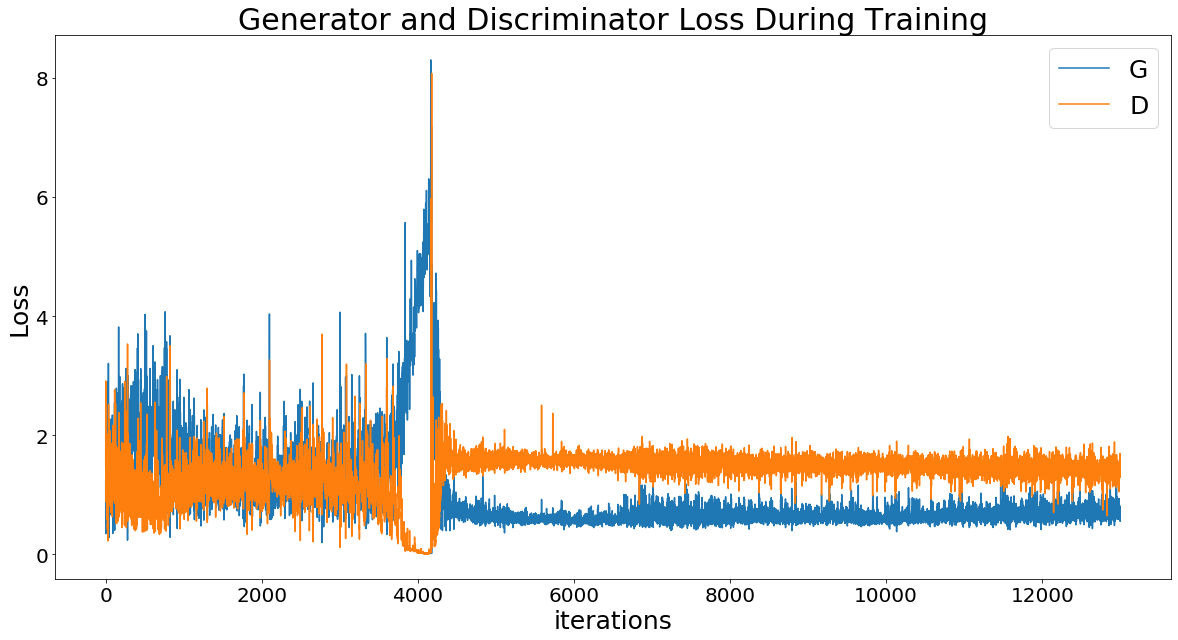

In [6]:
font1 = {'family' : 'Times',
'weight' : 'normal',
'size'   : 25,
}
plt.figure(figsize=(20,  10))
plt.title("Generator and Discriminator Loss During Training",fontsize=30)
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.tick_params(labelsize=20)
plt.legend(prop = font1)
plt.savefig("data1\loss.png",dpi = 600)
plt.show()

In [20]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)
save_path = 'data1\parameterniose03.pkl'
netG=torch.load(save_path)
z = torch.randn(10000,100, 1, 1, device=device)
fake = netG(z).detach().cpu()
fake=fake.reshape(-1,8)
print(fake[:100])
np.savetxt('data1/generatedata.csv',fake,delimiter=',')

c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

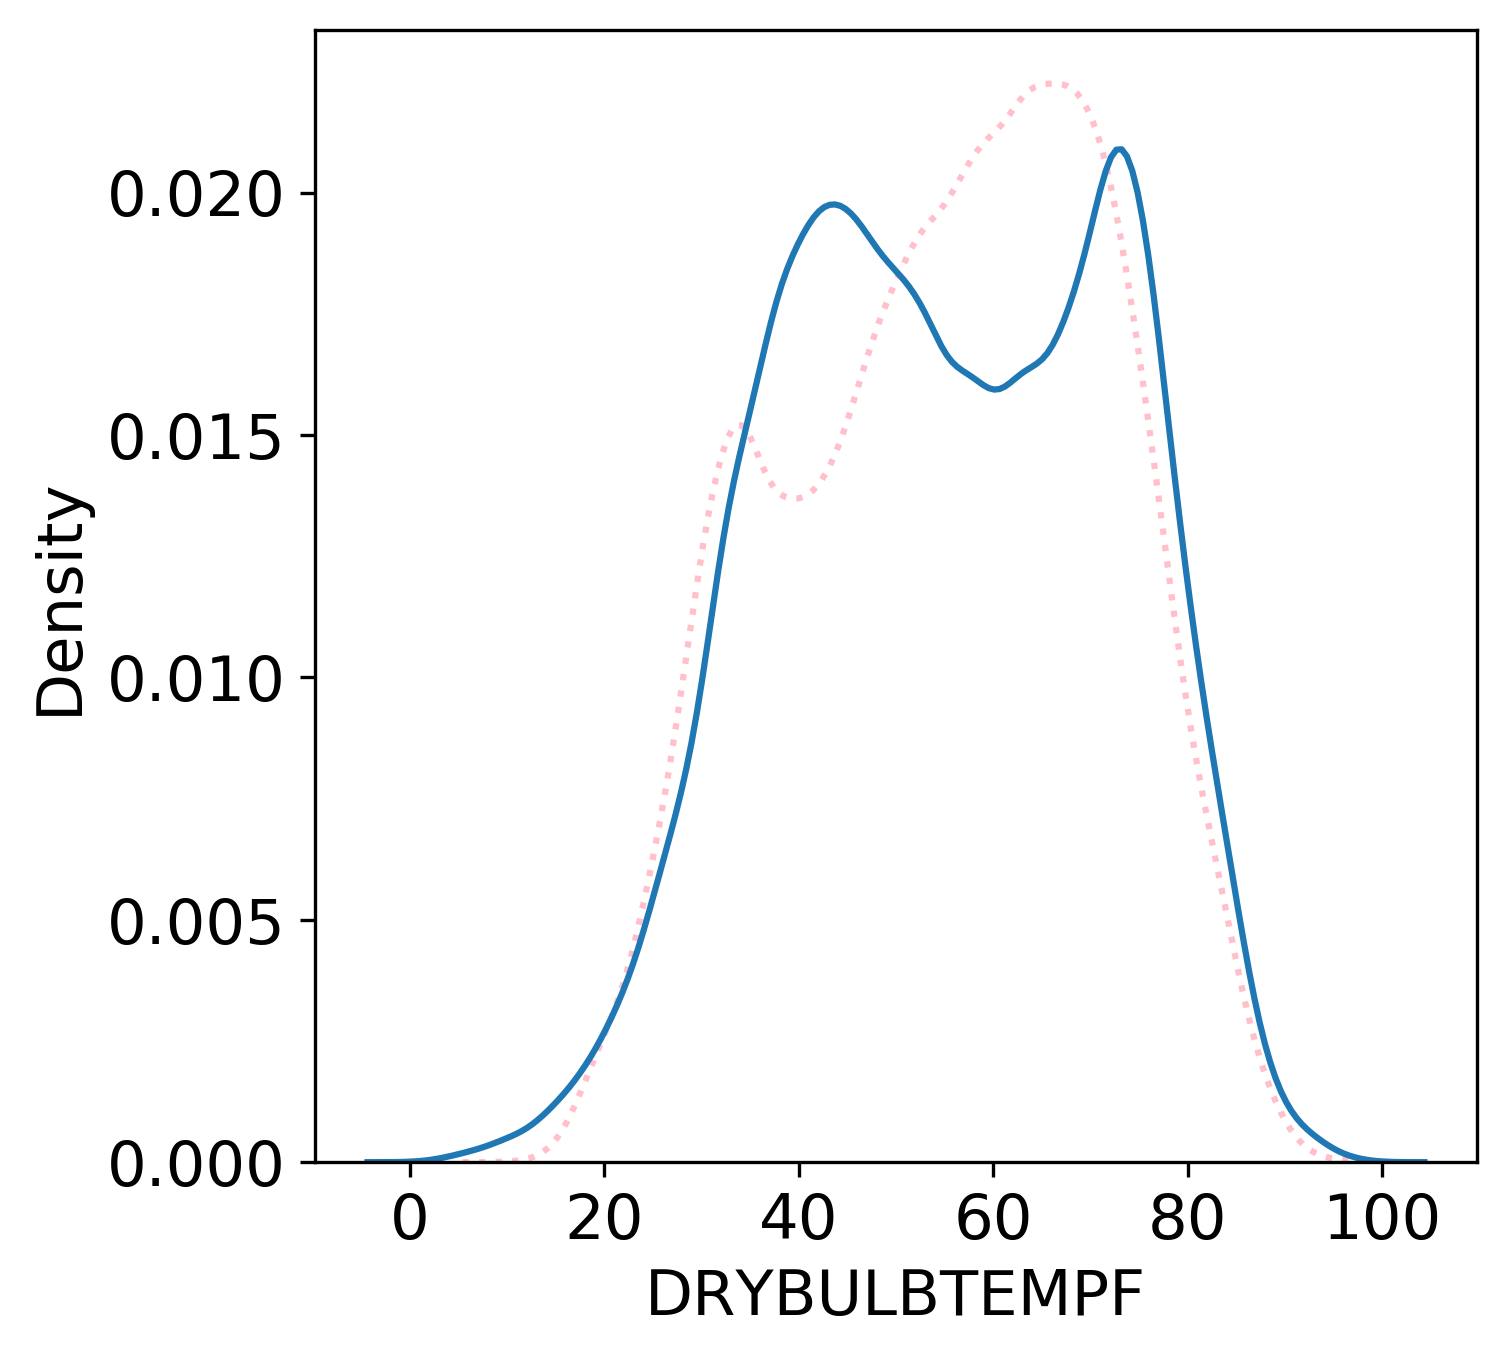

c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

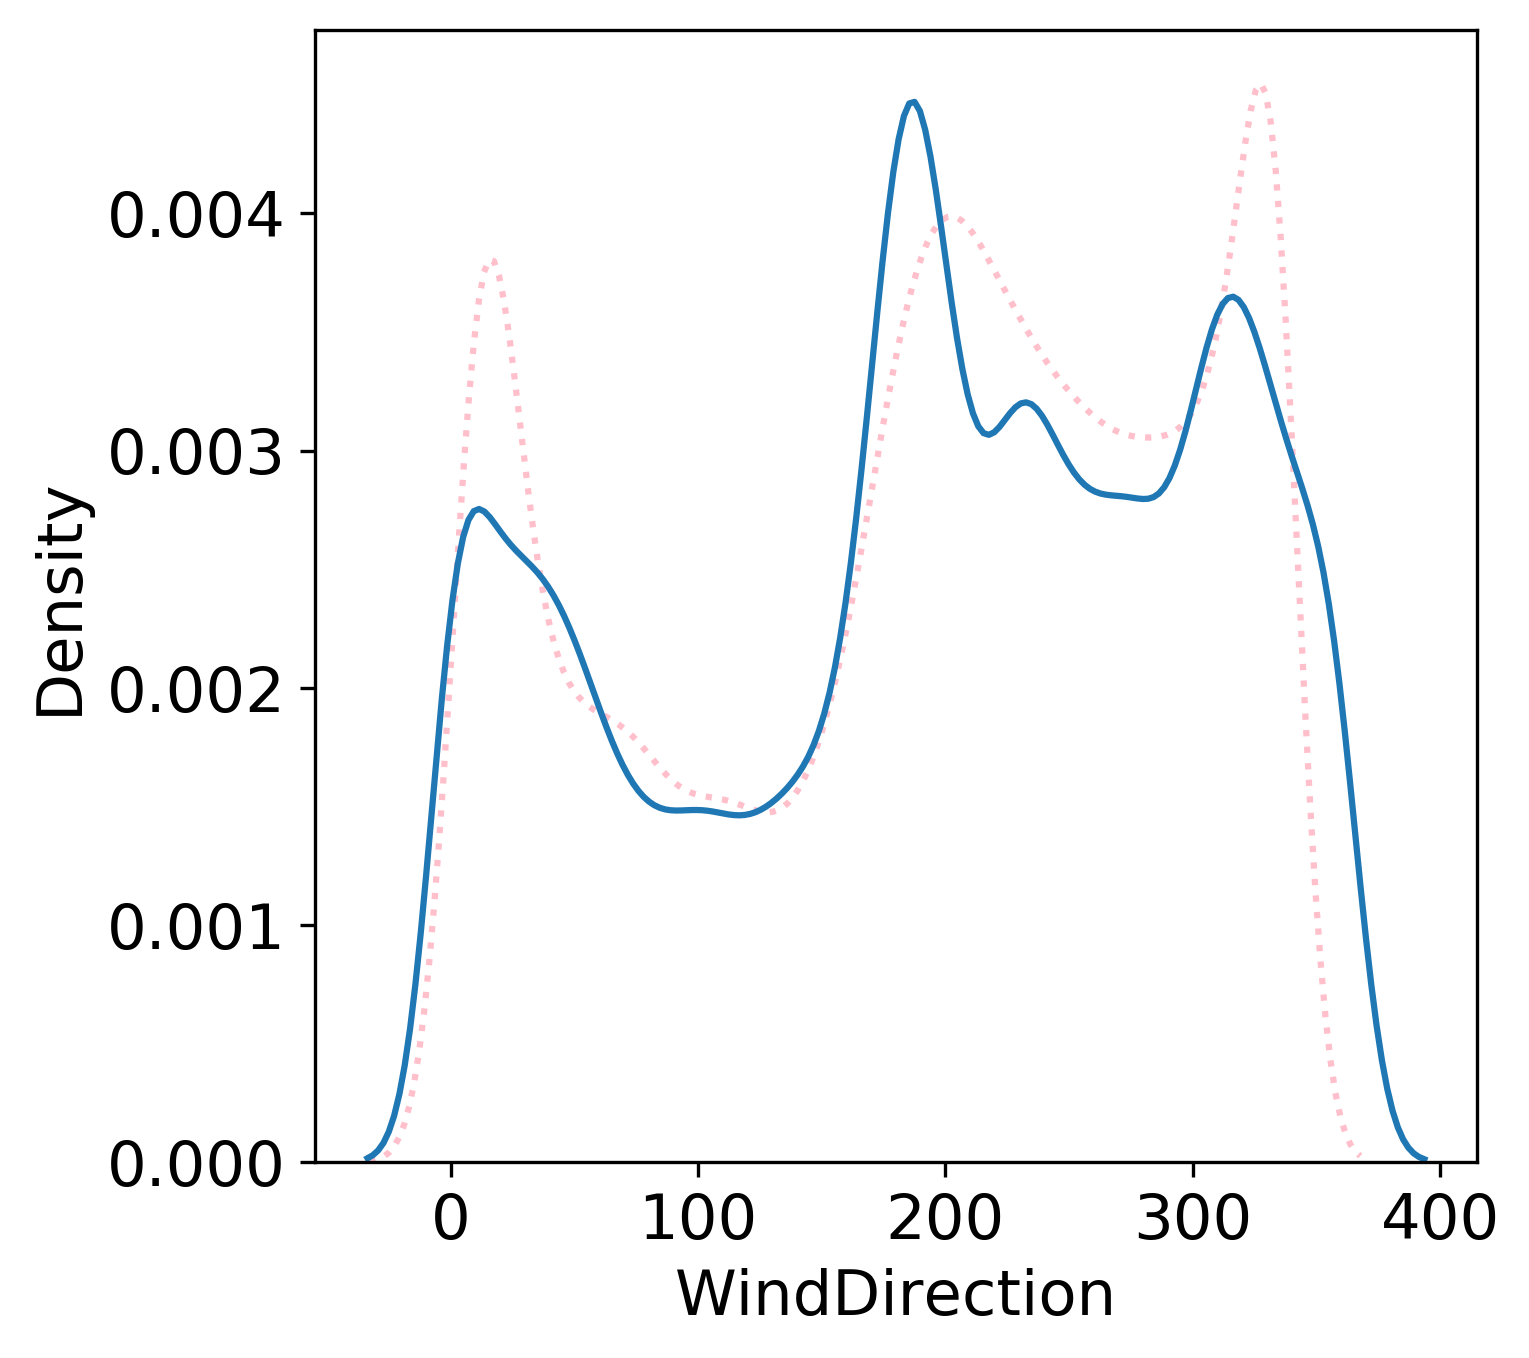

c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

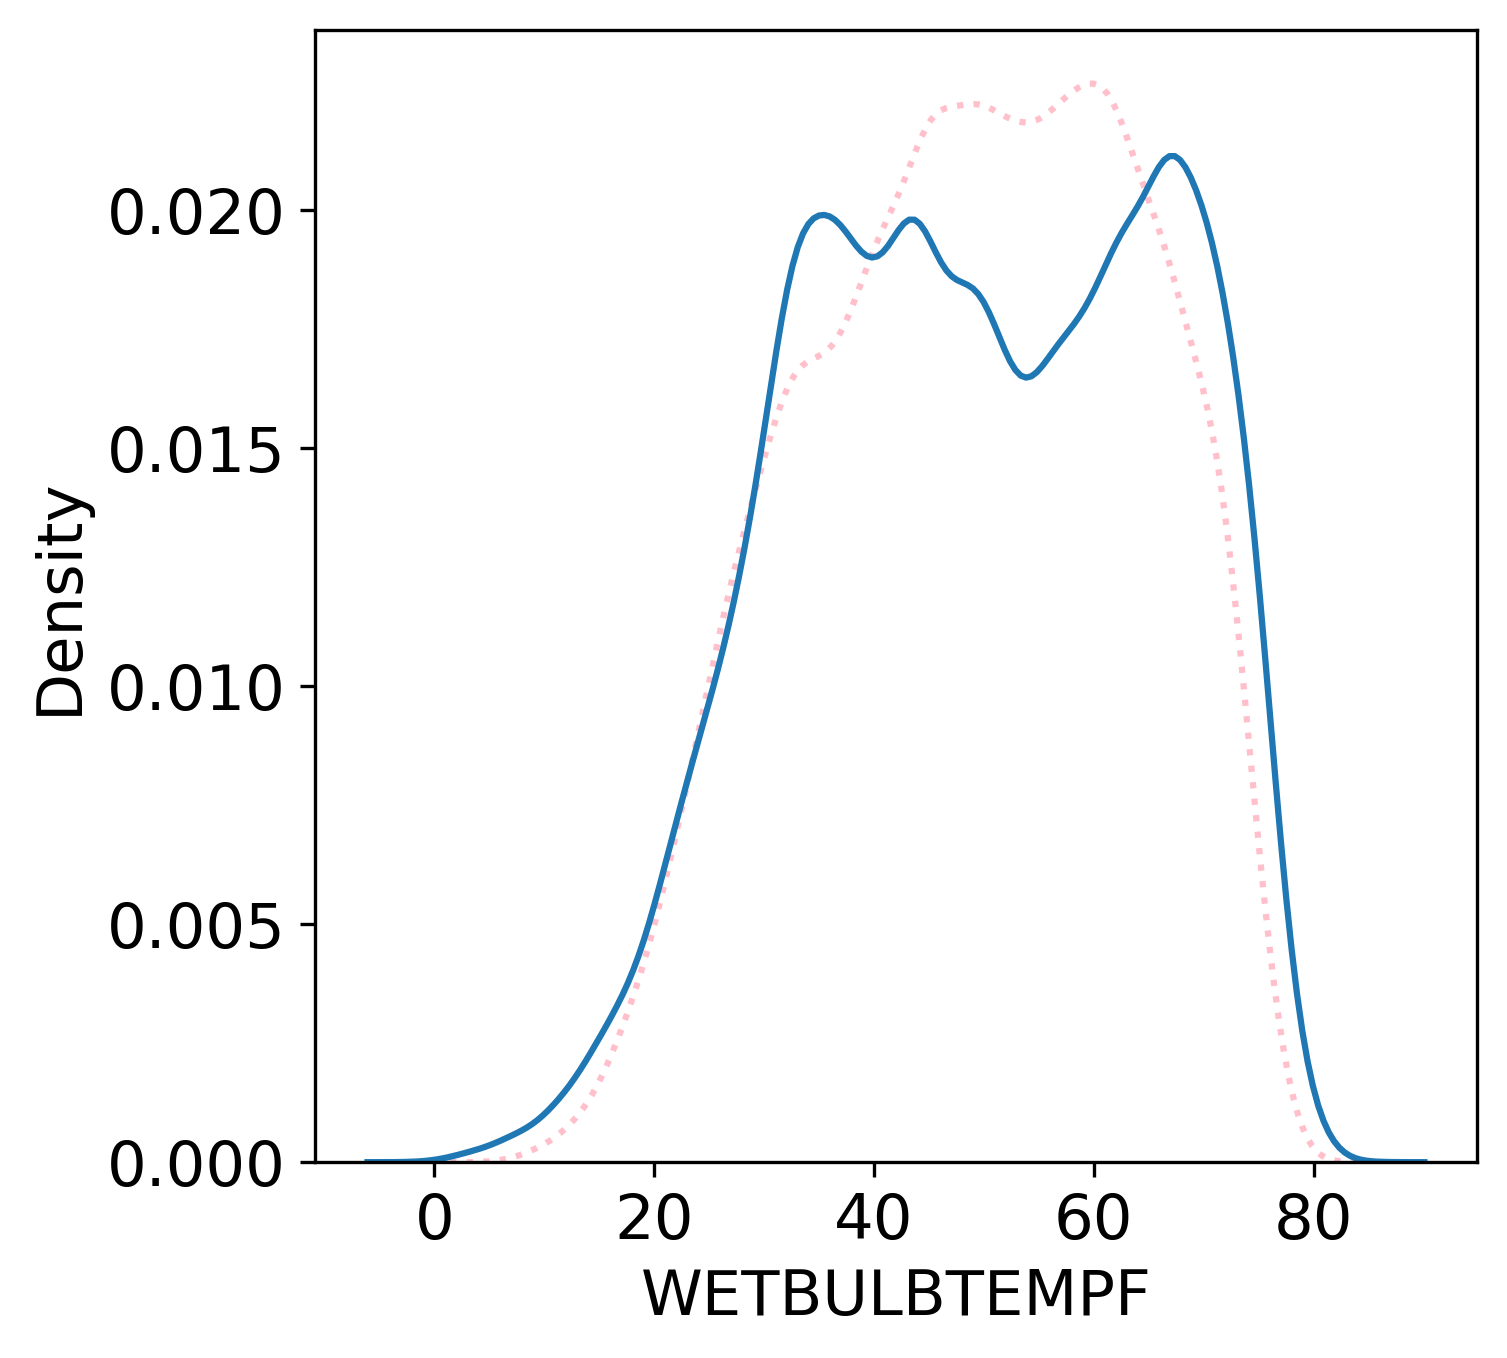

c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

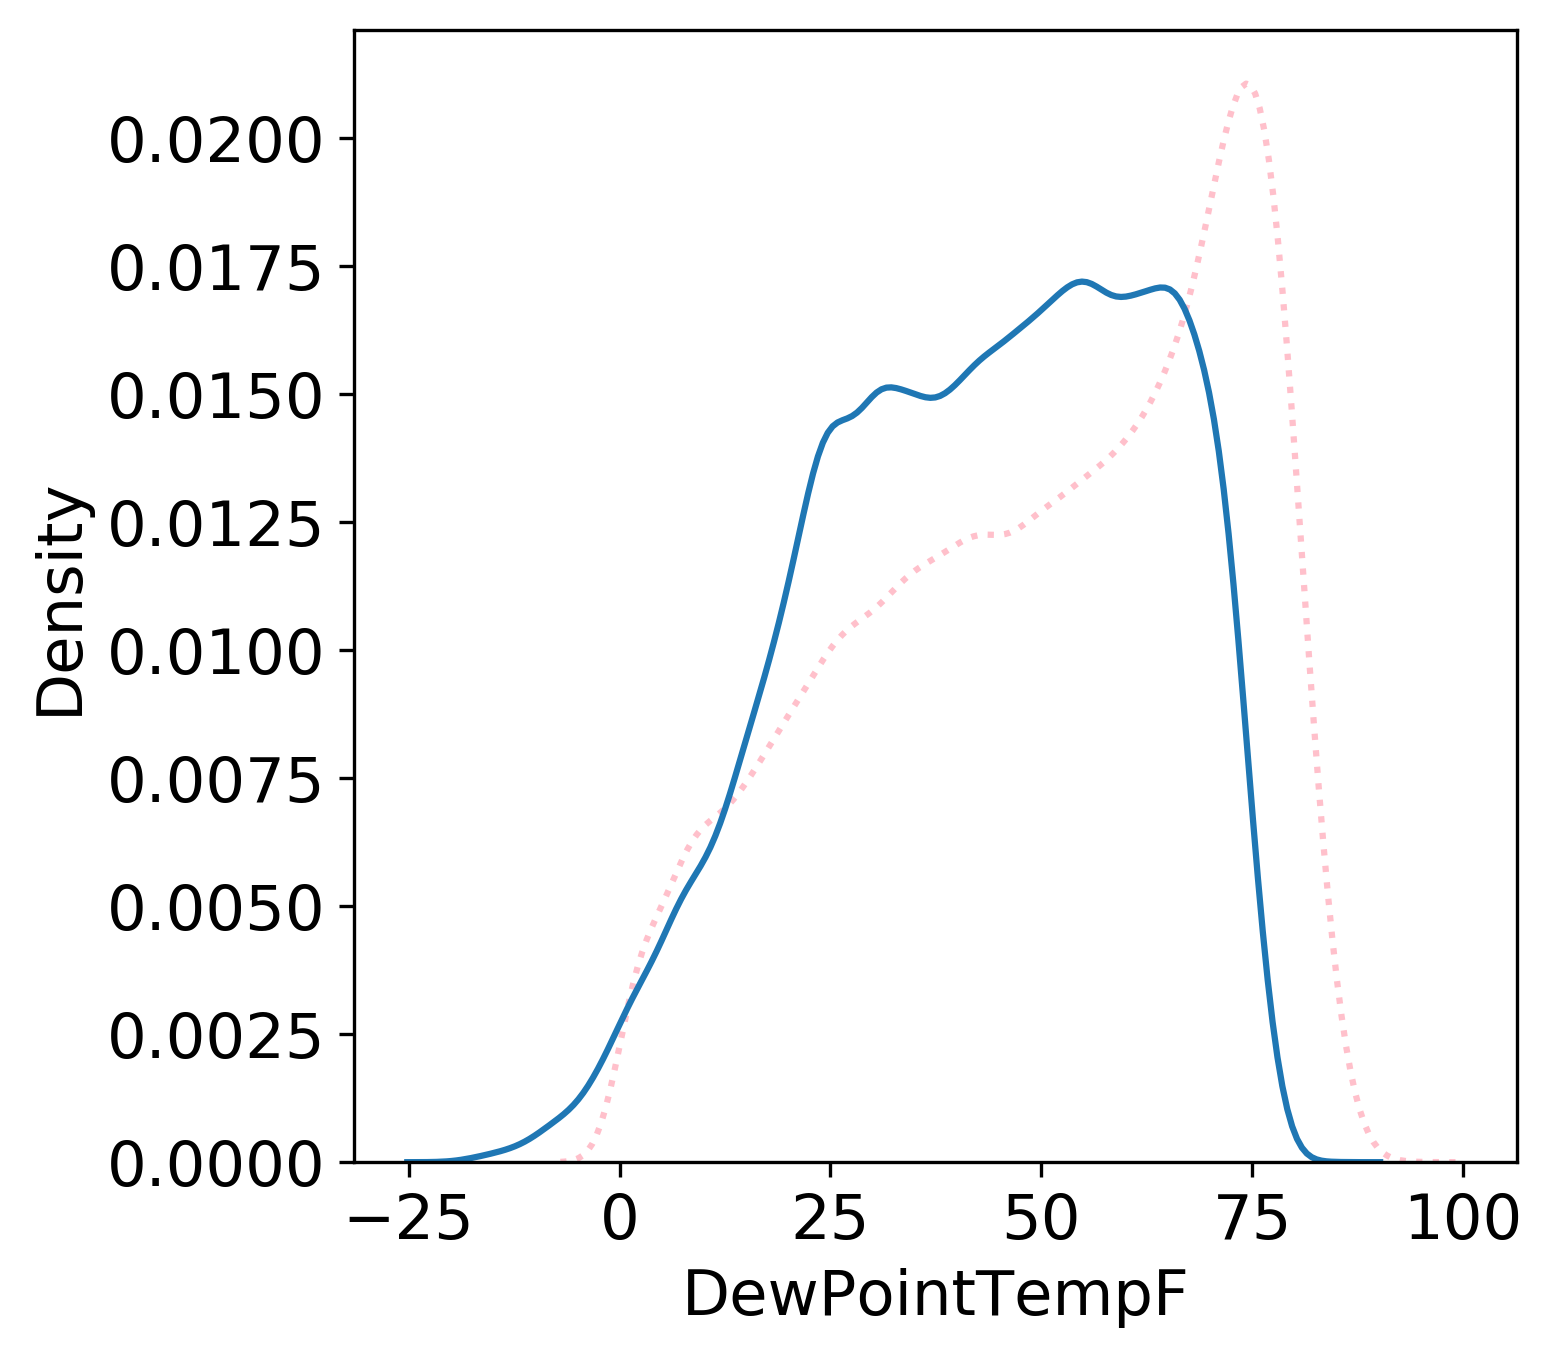

In [17]:
weather = pd.read_csv('data1/jfk_weather_cleaned_1.csv')

data1=fake_weather['DRYBULBTEMPF']
data2=weather['DRYBULBTEMPF']
# data3=fake_weather_with_noise['DRYBULBTEMPF']
fig = plt.figure(figsize=(5, 5), dpi=300)

# sns.kdeplot(data3,color="green",ls='-.')  # kde 核密度估计
sns.kdeplot(data1,color="pink",ls=':')  # kde 核密度估计
sns.distplot(data2,hist=False, kde=True)

plt.tick_params(labelsize=15)
font2 = {
'weight' : 'normal',
'size'   : 15,
}
plt.xlabel('DRYBULBTEMPF',font2)
plt.ylabel("Density",font2)
plt.show()
# plt.show()


data1=fake_weather['WindDirection']
data2=weather['WindDirection']
# data3=fake_weather_with_noise['WindDirection']
fig = plt.figure(figsize=(5, 5), dpi=300)

# sns.kdeplot(data3,color="green",ls='-.')  # kde 核密度估计
# hist=False
# plt.hist(data1, bins, normed=True, color="#FF0000", alpha=.9)
sns.kdeplot(data1,color="pink",ls=':')  # kde 核密度估计
sns.distplot(data2,hist=False, kde=True)



# labels = ax.get_xticklabels() + ax.get_yticklabels()
# [label.set_fontname('Times New Roman')]
plt.tick_params(labelsize=15)
font2 = {
'weight' : 'normal',
'size'   : 15,
}
plt.xlabel('WindDirection',font2)
plt.ylabel("Density",font2)
plt.show()

data1=fake_weather['WETBULBTEMPF']
data2=weather['WETBULBTEMPF']
# data3=fake_weather_with_noise['WETBULBTEMPF']
fig = plt.figure(figsize=(5, 5), dpi=300)

# sns.kdeplot(data3,color="green",ls='-.')  # kde 核密度估计
# plt.hist(data1, bins, normed=True, color="#FF0000", alpha=.9)
sns.kdeplot(data1,color="pink",ls=':')  # kde 核密度估计
sns.distplot(data2,hist=False, kde=True)
plt.tick_params(labelsize=15)
font2 = {
'weight' : 'normal',
'size'   : 15,
}
plt.xlabel('WETBULBTEMPF',font2)
plt.ylabel("Density",font2)
plt.show()


data1=fake_weather['DewPointTempF']
data2=weather['DewPointTempF']
# data3=fake_weather_with_noise['DewPointTempF']
fig = plt.figure(figsize=(5, 5), dpi=300)

# sns.kdeplot(data3,color="green",ls='-.')  # kde 核密度估计
# plt.hist(data1, bins, normed=True, color="#FF0000", alpha=.9)
sns.kdeplot(data1,color="pink",ls=':')  # kde 核密度估计
sns.distplot(data2,hist=False, kde=True)

plt.tick_params(labelsize=15)
font2 = {
'weight' : 'normal',
'size'   : 15,
}
plt.xlabel('DewPointTempF',font2)
plt.ylabel("Density",font2)
plt.show()

# data1=fake_weather['WindSpeed']
# data2=weather['WindSpeed']
# fig = plt.figure(figsize=(5, 5), dpi=300)
# # plt.hist(data1, bins, normed=True, color="#FF0000", alpha=.9)
# sns.distplot(data1,hist=True, kde=True,color="pink")  # kde 核密度估计
# sns.distplot(data2,hist=True, kde=True)
# plt.tick_params(labelsize=15)
# font2 = {
# 'weight' : 'normal',
# 'size'   : 15,
# }
# plt.xlabel('DewPointTempF',font2)
# plt.ylabel("Density",font2)
# plt.show()